In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset

In [3]:
digit_to_word = {
    "0": "zero",
    "1": "one",
    "2": "two",
    "3": "three",
    "4": "four",
    "5": "five",
    "6": "six",
    "7": "seven",
    "8": "eight",
    "9": "nine"
}

def generate_pair(max_len=5):
    length = random.randint(1, max_len)
    digits = [str(random.randint(0, 9)) for _ in range(length)]
    input_seq = "".join(digits)
    output_seq = " ".join(digit_to_word[d] for d in digits)
    return input_seq, output_seq

# Vocabulary

In [5]:
special_tokens = ["<pad>", "<sos>", "<eos>"]

input_chars = list("0123456789")
output_chars = list("abcdefghijklmnopqrstuvwxyz ")

input_vocab = special_tokens + input_chars
output_vocab = special_tokens + output_chars

input_stoi = {c: i for i, c in enumerate(input_vocab)}
output_stoi = {c: i for i, c in enumerate(output_vocab)}

input_itos = {i: c for c, i in input_stoi.items()}
output_itos = {i: c for c, i in output_stoi.items()}

# Encoding utilities

In [7]:
def encode(seq, stoi):
    return [stoi[c] for c in seq]

# Encoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (h, c) = self.lstm(embedded)
        return h, c

# Decoder

In [11]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        outputs, hidden = self.lstm(embedded, hidden)
        logits = self.fc(outputs)
        return logits, hidden

# Seq2Seq

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt):
        hidden = self.encoder(src)
        outputs, _ = self.decoder(tgt, hidden)
        return outputs

# Model setup

In [15]:
emb_dim = 64
hidden_dim = 128

encoder = Encoder(len(input_vocab), emb_dim, hidden_dim).to(device)
decoder = Decoder(len(output_vocab), emb_dim, hidden_dim).to(device)
model = Seq2Seq(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=output_stoi["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [17]:
epoch_losses = []

for epoch in range(20):
    model.train()
    total_loss = 0

    for _ in range(200):
        src_text, tgt_text = generate_pair()

        src = encode(src_text, input_stoi)
        tgt = ["<sos>"] + list(tgt_text) + ["<eos>"]
        tgt = encode(tgt, output_stoi)

        src_tensor = torch.tensor(src).unsqueeze(1).to(device)
        tgt_tensor = torch.tensor(tgt).unsqueeze(1).to(device)

        optimizer.zero_grad()
        output = model(src_tensor, tgt_tensor[:-1])

        loss = criterion(
            output.view(-1, output.shape[-1]),
            tgt_tensor[1:].view(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_losses.append(total_loss)
    print(f"Epoch {epoch+1:02d} | Loss: {total_loss:.3f}")

Epoch 01 | Loss: 314.074
Epoch 02 | Loss: 96.976
Epoch 03 | Loss: 66.916
Epoch 04 | Loss: 51.164
Epoch 05 | Loss: 46.160
Epoch 06 | Loss: 41.413
Epoch 07 | Loss: 34.854
Epoch 08 | Loss: 24.327
Epoch 09 | Loss: 19.816
Epoch 10 | Loss: 20.888
Epoch 11 | Loss: 17.360
Epoch 12 | Loss: 15.889
Epoch 13 | Loss: 13.570
Epoch 14 | Loss: 15.670
Epoch 15 | Loss: 13.787
Epoch 16 | Loss: 11.617
Epoch 17 | Loss: 11.880
Epoch 18 | Loss: 11.975
Epoch 19 | Loss: 9.817
Epoch 20 | Loss: 7.835


# Training loss visualization

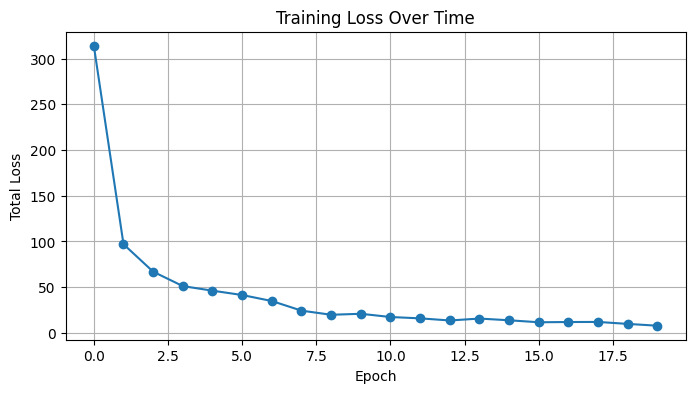

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(epoch_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()

# Translation

In [28]:
def translate(seq):
    model.eval()
    src = torch.tensor(encode(seq, input_stoi)).unsqueeze(1).to(device)

    with torch.no_grad():
        hidden = encoder(src)
        inp = torch.tensor([[output_stoi["<sos>"]]]).to(device)
        result = []

        for _ in range(50):
            logits, hidden = decoder(inp, hidden)
            pred = logits.argmax(-1).item()

            if pred == output_stoi["<eos>"]:
                break

            result.append(output_itos[pred])
            inp = torch.tensor([[pred]]).to(device)

    return "".join(result)

print("\nTranslations:")
print("123 →", translate("123"))
print("507 →", translate("507"))
print("89  →", translate("89"))


Translations:
123 → one two three
507 → five zero seven
89  → eight nine


# Decoder probability heatmap

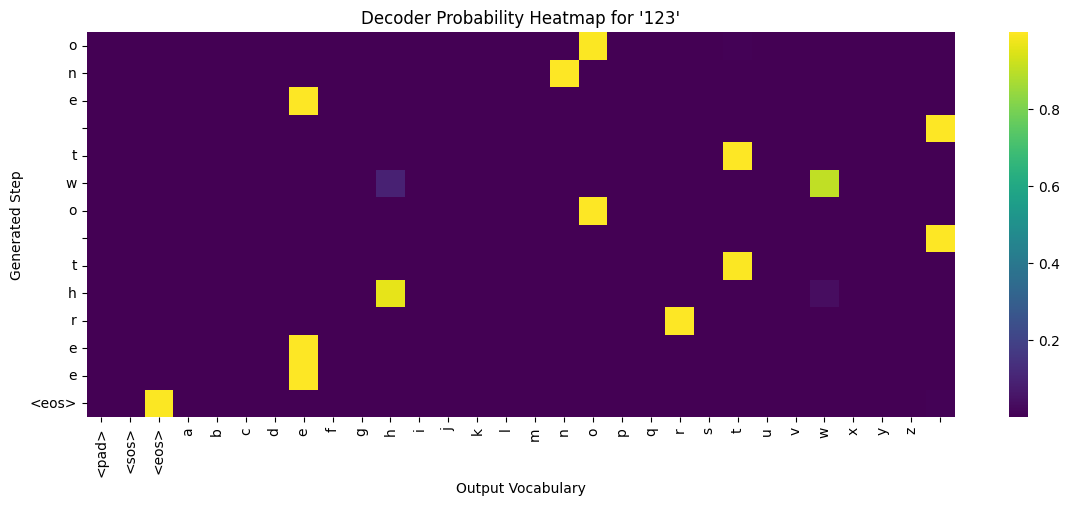

In [30]:
def visualize_decoder_probs(seq):
    model.eval()
    src = torch.tensor(encode(seq, input_stoi)).unsqueeze(1).to(device)

    with torch.no_grad():
        hidden = encoder(src)
        inp = torch.tensor([[output_stoi["<sos>"]]]).to(device)

        probs = []
        labels = []

        for _ in range(30):
            logits, hidden = decoder(inp, hidden)
            p = torch.softmax(logits[0, 0], dim=0)

            pred = p.argmax().item()
            labels.append(output_itos[pred])
            probs.append(p.cpu().numpy())

            if pred == output_stoi["<eos>"]:
                break

            inp = torch.tensor([[pred]]).to(device)

    probs = np.array(probs)

    plt.figure(figsize=(14, 5))
    sns.heatmap(
        probs,
        xticklabels=output_vocab,
        yticklabels=labels,
        cmap="viridis"
    )

    plt.xlabel("Output Vocabulary")
    plt.ylabel("Generated Step")
    plt.title(f"Decoder Probability Heatmap for '{seq}'")
    plt.show()

visualize_decoder_probs("123")

# Embedding PCA visualization

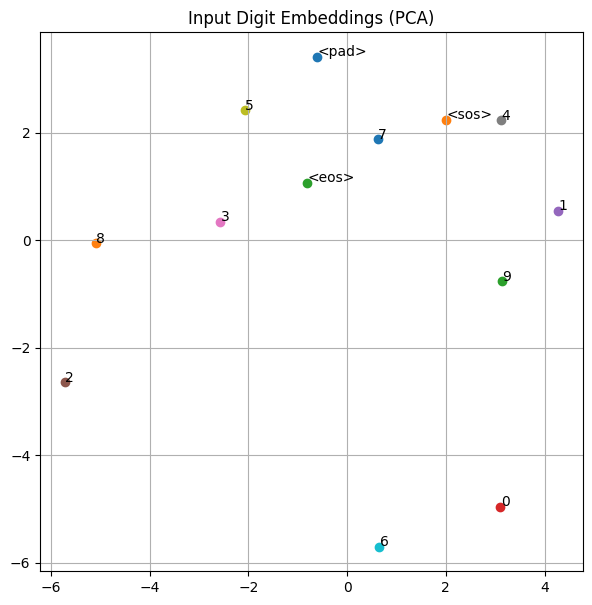

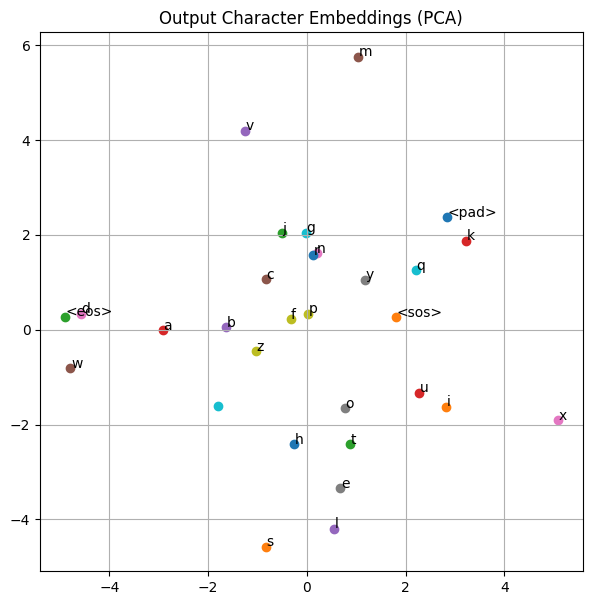

In [32]:
def visualize_embeddings(embedding, vocab, title):
    weights = embedding.weight.detach().cpu().numpy()
    reduced = PCA(n_components=2).fit_transform(weights)

    plt.figure(figsize=(7, 7))
    for i, token in enumerate(vocab):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, token)

    plt.title(title)
    plt.grid(True)
    plt.show()

visualize_embeddings(encoder.embedding, input_vocab, "Input Digit Embeddings (PCA)")
visualize_embeddings(decoder.embedding, output_vocab, "Output Character Embeddings (PCA)")

# Step-by-step decoding visualization

In [35]:
def visualize_translation_steps(seq):
    model.eval()
    src = torch.tensor(encode(seq, input_stoi)).unsqueeze(1).to(device)

    with torch.no_grad():
        hidden = encoder(src)
        inp = torch.tensor([[output_stoi["<sos>"]]]).to(device)

        print(f"\nDecoding steps for '{seq}':")
        print("-" * 45)

        for step in range(30):
            logits, hidden = decoder(inp, hidden)
            probs = torch.softmax(logits[0, 0], dim=0)
            pred = probs.argmax().item()

            print(
                f"Step {step:02d} | "
                f"Pred: '{output_itos[pred]}' | "
                f"Confidence: {probs[pred]:.3f}"
            )

            if pred == output_stoi["<eos>"]:
                break

            inp = torch.tensor([[pred]]).to(device)

visualize_translation_steps("507")


Decoding steps for '507':
---------------------------------------------
Step 00 | Pred: 'f' | Confidence: 0.982
Step 01 | Pred: 'i' | Confidence: 0.996
Step 02 | Pred: 'v' | Confidence: 0.998
Step 03 | Pred: 'e' | Confidence: 1.000
Step 04 | Pred: ' ' | Confidence: 1.000
Step 05 | Pred: 'z' | Confidence: 0.730
Step 06 | Pred: 'e' | Confidence: 1.000
Step 07 | Pred: 'r' | Confidence: 0.999
Step 08 | Pred: 'o' | Confidence: 0.998
Step 09 | Pred: ' ' | Confidence: 0.998
Step 10 | Pred: 's' | Confidence: 0.995
Step 11 | Pred: 'e' | Confidence: 0.996
Step 12 | Pred: 'v' | Confidence: 0.999
Step 13 | Pred: 'e' | Confidence: 1.000
Step 14 | Pred: 'n' | Confidence: 0.999
Step 15 | Pred: '<eos>' | Confidence: 0.999
